# Reconnaissance d’objets par appariement des points d’intérêt

The objective of this lab is to develop an object recognition program based on the matching of feature points extarcted from images.

**Extraction of feature points**

In this phase, we will extract feature points such as SIFT (Scale-Invariant Feature Transform) from a set of reference images and store them in the form of a suitable data structure. The SIFT descriptor and others are already implemented in opencv in the cv2.xfeatures2d package.

Since corners are interesting features of an image. Feature detection algorithms started by detecting corners. There are a number of techniques in OpenCV to detect features. Here are the most popular feature detectors:

* Haris corner detection
* Shi-Tomasi corner detection
* SIFT (Scale-Invariant Feature Transform)
* SURF (Speeded-Up Robust Features)
* FAST algorithm for corner detection
* ORB (Oriented FAST and Rotated Brief)

**SIFT (Scale-Invariant Feature Transform):**

SIFT is both rotation and scale invariant. It provides keypoints and keypoint descriptors where the keypoint descriptor describes the keypoint at a selected scale and rotation with image gradients. We display SIFT with circles representing key points/features, where the size of the circle represents the strength of the key point and the line inside the circle indicates the orientation of the key point.

SIFT is patented and not freely available for commercial use. It requires opencv-contrib to be installed in order to use them

In [ ]:
# monter votre Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Centrale-ML4V/Data.zip"

with ZipFile(file_name, 'r') as zip_:
  zip_.extractall()
  print('Done')

Done


In [ ]:
!pip install -U opencv-python

Images can be daownloded here:
https://drive.google.com/file/d/1utzjL4tOpeS9yWmBEw9tUuzsq1NXZw2M/view?usp=sharing

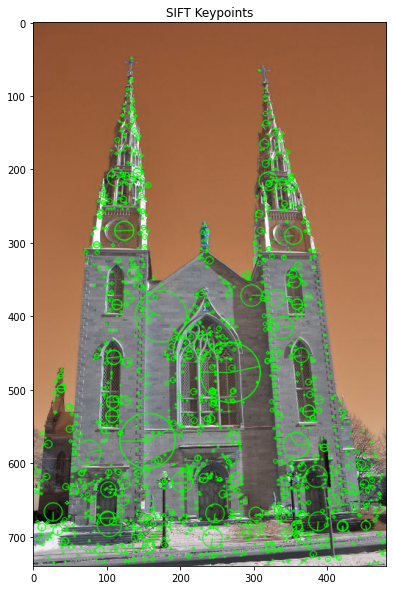

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('Data/church01.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# use orb if sift is not installed
feature_extractor = cv2.SIFT_create()

# find the keypoints and descriptors with chosen feature_extractor
kp, desc = feature_extractor.detectAndCompute(gray_img, None)

kp_img = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0),  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

figsize = (10, 10)
plt.figure(figsize=figsize)
plt.imshow(kp_img)
plt.title("SIFT Keypoints")
plt.show()

**Feature matching** :
Matching features between images can be done with:

* Brute-Force (BF) Matcher: it matches the descriptor of a feature of an image with all the other features of another image and returns the match according to the distance. It is slow because it checks the correspondence with all the characteristics.
* Flannmatcher: Fast Library for Fuzzy Nearest Neighbors (FLANN) is optimized to find matches with search even with large datasets, hence its speed compared to Brute-Force matcher.

First, load an image "image", initialize the SIFT detector and then calculate the feature points and the corresponding descriptors:

In [ ]:
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import cv2

rgb_l = cv2.cvtColor(cv2.imread("Data/church01.jpg"), cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
rgb_r = cv2.cvtColor(cv2.imread("Data/church02.jpg"), cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(rgb_r, cv2.COLOR_RGB2GRAY)

In [ ]:
#feature_extractor = cv2.xfeatures2d.SIFT_create()
feature_extractor = cv2.SIFT_create()

# find the keypoints and descriptors with chosen feature_extractor
kp_l, desc_l = feature_extractor.detectAndCompute(gray_l, None)
kp_r, desc_r = feature_extractor.detectAndCompute(gray_r, None)

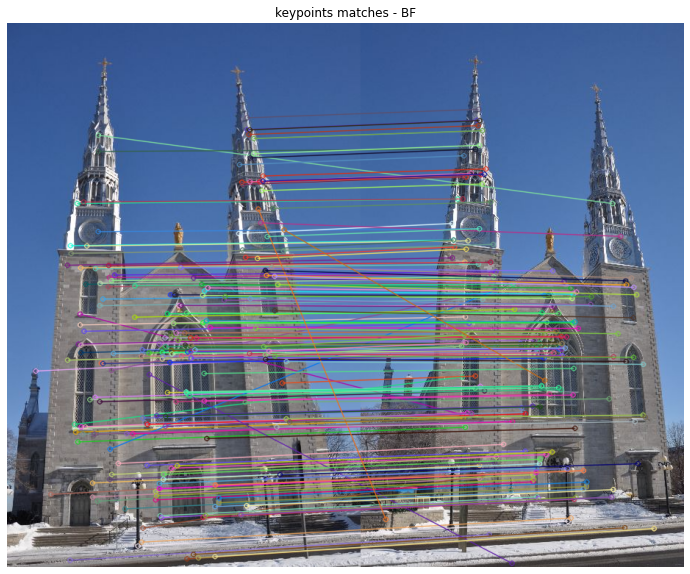

(<matplotlib.image.AxesImage at 0x7fbed8ecb040>, None)

In [ ]:
#Brute-Force (BF) Matcher:

bf = cv2.BFMatcher()
matches = bf.knnMatch(desc_l, desc_r, k=2)

# store all the good matches as per Lowe's ratio test.
good_match = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_match.append(m)

src_pts = np.float32([ kp_l[m.queryIdx].pt for m in good_match ]).reshape(-1, 2)
dst_pts = np.float32([ kp_r[m.trainIdx].pt for m in good_match ]).reshape(-1, 2)

matches = cv2.drawMatches(rgb_l,kp_l,rgb_r,kp_r, good_match,None, flags=2)
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title("keypoints matches - BF") 
plt.imshow(matches),plt.show()  

Many of the correspondences are faulty and simply estimating the parameter set with all coordinates is not sufficient. Therefore, the RANSAC (RANdom Sample Consensus) algorithm is used on top of the normal model to robustly estimate the parameter set by detecting outliers.

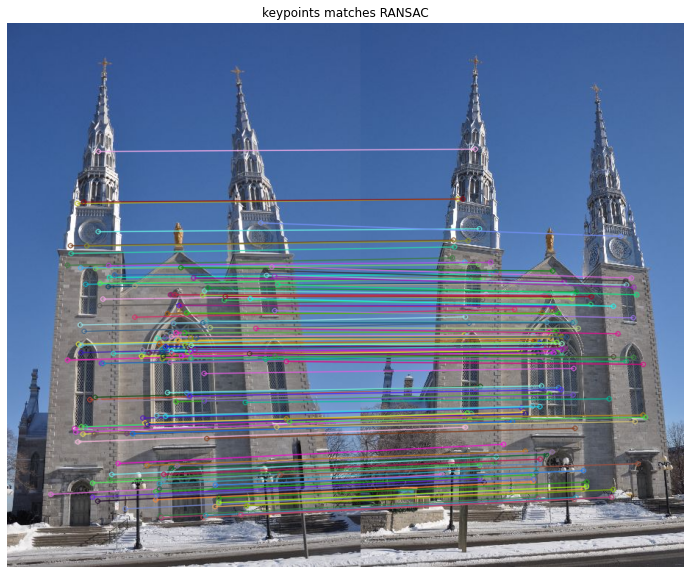

(<matplotlib.image.AxesImage at 0x7fbecd131280>, None)

In [ ]:
# Ransac

from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, AffineTransform

model, inliers = ransac(
        (src_pts, dst_pts),
        AffineTransform, min_samples=4,
        residual_threshold=8, max_trials=10000
    )

n_inliers = np.sum(inliers)

inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in src_pts[inliers]]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in dst_pts[inliers]]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
#image3 = cv2.drawMatches(img1, inlier_keypoints_left, img2, inlier_keypoints_right, placeholder_matches, None)

#plt.imshow(image3)

matches_ran = cv2.drawMatches(rgb_l,inlier_keypoints_left,rgb_r,inlier_keypoints_right, placeholder_matches,None, flags=2)
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title("keypoints matches RANSAC") 
plt.imshow(matches_ran),plt.show()


**Image clssification/retrieval by visual content (Bag of Visual Words)**

Bag of visual words or Bag of features (BoF) is one of the most used approaches for the classification and retrieval of visual data. It is inspired by a concept called Bag of Words used in document classification. A bag of words is a simple word count vector; that is, a sparse histogram on the vocabulary. In computer vision, an entity sight word packet is a simple occurrence count vector of a local entity vocabulary.

The objective of the lab is to develop an image search system by visual content that is efficient for large image collections. Conventionally, a system for searching for images by visual content comprises an off-line phase for indexing the image database and an on-line search phase proper.
We start with a classification process and we will see how to transform it into a content search system (search engine). The classification process consists of two main phases:

1. Learning phase: this phase consists of calculating SIFT descriptors

(Scale-Invariant Feature Transform) from a set of reference images and store them as a convenient data structure for easy reuse.


In [ ]:
# Importer les packages nécessaires :

import argparse as ap
import cv2
import imutils
import numpy as np
import os
import matplotlib.pylab as plt
from sklearn.svm import LinearSVC

from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors

from sklearn import preprocessing

Download the image data (dataset-classif.zip:
https://drive.google.com/file/d/1YLcCKCNFNRqTqjIKObwTzsb4GAVLNLFK/view?usp=sharing

Provide the path to the learning data in your code, and parse the data folders to organize the class labels.

In [ ]:
# monter votre Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Centrale-ML4V/Data-BoW.zip"

with ZipFile(file_name, 'r') as zip_:
  zip_.extractall()
  print('Done')

Done


In [ ]:
# Get the path of the training set
train_path = './Data-BoW/dataset-classif/train/'
# Get the training classes names and store them in a list
training_names = os.listdir(train_path)

def imlist(path):
    """
    The function imlist returns all the names of the files in 
    the directory path supplied as argument to the function.
    """
    return [os.path.join(path, f) for f in os.listdir(path)]

# Get all the path to the images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0
for training_name in training_names:
    dir = os.path.join(train_path, training_name)
    class_path = imlist(dir)
    image_paths += class_path
    image_classes += [class_id] * len(class_path)
    class_id += 1

Start by extracting the SIFT points in all the images. Then store the descriptors around these points in a list.

In [ ]:
# Create feature extraction and keypoint detector objects
des_list = []

sift = cv2.SIFT_create()

for image_path in image_paths:
    im = cv2.imread(image_path)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    des_list.append((image_path, des))

Stack all descriptors into a numpy array

In [ ]:
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor))

Now, apply clustering to create a vocabulary of (here 100) visual words
k = 100
voc, variance = kmeans(descriptors, k, 1)

Then, calculate the histograms of the features, using vector quantization which allows us to create our vocabulary of visual words.

In [ ]:
# Perform k-means clustering
k = 100
print ("Start k-means: %d words, %d key points" % (k, descriptors.shape[0]))

voc, variance = kmeans(descriptors, k, 1)

# Calculate the histogram of features
im_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1], voc)
    for w in words:
        im_features[i][w] += 1

Start k-means: 100 words, 11799 key points


In [ ]:
#transform vector
nbr_occurences = np.sum((im_features>0)*1,axis=0)
idf = np.array(np.log((1.0*len(image_paths)+1)/(1.0*nbr_occurences+1)),'float32')
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

With the histograms obtained for each class, we can train a classifier (knn, svm, …)

In [ ]:
kn = 5
# Train the Linear SVM
clf = LinearSVC()
#clf = neighbors.KNeighborsClassifier()
#clf = neighbors.KNeighborsClassifier(kn,weights='uniform',p=2,metric='minkowski')
clf.fit(im_features, np.array(image_classes))

LinearSVC()

You can save the model resulting from the training, which contains the classifier, the class names, the transformation vector, the number of clusters and the vocabulary. This makes it possible to separate the two phases, learning and testing.

In [ ]:
#from sklearn.externals import joblib
#!pip install joblib

In [ ]:
# Save the model
import joblib
joblib.dump((clf, training_names, stdSlr, k, voc), "bof_class.pkl", compress=3)

['bof_class.pkl']

2- In the test phase, the following steps must be applied:

load the model,
load the test images (as for the training)
calculate SIFT descriptors in test images (as for the training)
apply the prediction function to predict the class of each test image.

In [ ]:
# chargement du modèle:
clf, classes_names, stdSlr, k, voc = joblib.load("bof_class.pkl")

In [ ]:
image_paths = []
test_path = './Data-BoW/dataset-classif/test/'
testing_names = os.listdir(test_path)
for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    class_path = imlist(dir)
    image_paths += class_path

In [ ]:
# chargement des images de teste
sift = cv2.SIFT_create()

# List où les descripeturs seront stoqués 
des_list = []
# calcul des descripteurs SIFT
for image_path in image_paths:
    im = cv2.imread(image_path)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    des_list.append((image_path, des))

# Empilez tous les descripteurs verticalement dans un tableau numpy
descriptors = des_list[0][1]
for image_path, descriptor in des_list[0:]:
    descriptors = np.vstack((descriptors, descriptor))

#
test_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1], voc)
    for w in words:
        test_features[i][w] += 1

In [ ]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum((test_features > 0) * 1, axis=0)
idf = np.array(np.log((1.0 * len(image_paths) + 1) / (1.0 * nbr_occurences + 1)), 'float32')

In [ ]:
# Scale the features
test_features = stdSlr.transform(test_features)

# Perform the predictions
predictions = [classes_names[i] for i in clf.predict(test_features)]

In [ ]:
# Visualize the results, if "visualize" flag set to true by the user

for image_path, prediction in zip(image_paths, predictions):
    image = cv2.imread(image_path)
    cv2.namedWindow("Image", cv2.WINDOW_NORMAL)
    pt = (0, 3 * image.shape[0] // 4)
    cv2.putText(image, prediction, pt, cv2.FONT_HERSHEY_SCRIPT_COMPLEX, 2, [0, 255, 0], 2)
    plt.imshow(image)
    cv2.waitKey(3000)

**Exercice 1:** 

Now, transform your classifier into a search engine that calculates a similarity score instead of predicting a label. In other words, it is the search by visual similarity from an example. In its simplest form, the system receives as input an example image (query) and returns the set of images most similar to this image, in the sense of the similarity measure associated with the signature (here the histogram calculated at from the visual vocabulary). The search involves finding the nearest neighbors of the signature associated with the query image. In this case, instead of learning a learning model, you should use a distance instead:

Use for this part of the lab the 'dataset-retr' 

In [ ]:
# Perform L2 normalization
im_features_r = preprocessing.normalize(im_features_r, norm='l2')
# export the model
joblib.dump((im_features, image_paths, idf, numWords, voc), "bof_retr.pkl", compress=3)

In the test phase (online research), we look for a score (we use for example the function np.dot() of numpy).

In [ ]:
score = np.dot(test_features, im_features.T)
rank_ID = np.argsort(-score)

**Exercice 2:** 

Now, use Convolutional Neural Network (CNN) as descriptors instead of SIFT keypoints and BoW for your search engine. Use a pretarined model like VGG16 for cnn feature extracing.